![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/SKEW_CORRECTION.ipynb)

# Correct skewness in scanned documents 

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Read licence key

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Install Dependencies

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

Importing Libraries

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

Start Spark Session

In [3]:
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



## 2. Load skewed scanned text image

In [4]:
rotatedPDF = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400/400_rot.pdf')
image_df = spark.read.format("binaryFile").load(rotatedPDF).cache()

## 3. Construct the OCR pipeline

In [5]:
pdf_to_image = PdfToImage()
pdf_to_image.setInputCol("content")
pdf_to_image.setOutputCol("image")

# Image skew corrector 
skew_corrector = ImageSkewCorrector()
skew_corrector.setInputCol("image")
skew_corrector.setOutputCol("corrected_image")
skew_corrector.setAutomaticSkewCorrection(True)

# Run OCR
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")

pipeline = PipelineModel(stages=[
    pdf_to_image,
    skew_corrector,
    ocr
])

## 4. Run OCR pipeline

In [6]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [7]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|FOREWORD

Electro...|95.61764068603516|
+--------------------+-----------------+



Display text and images


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


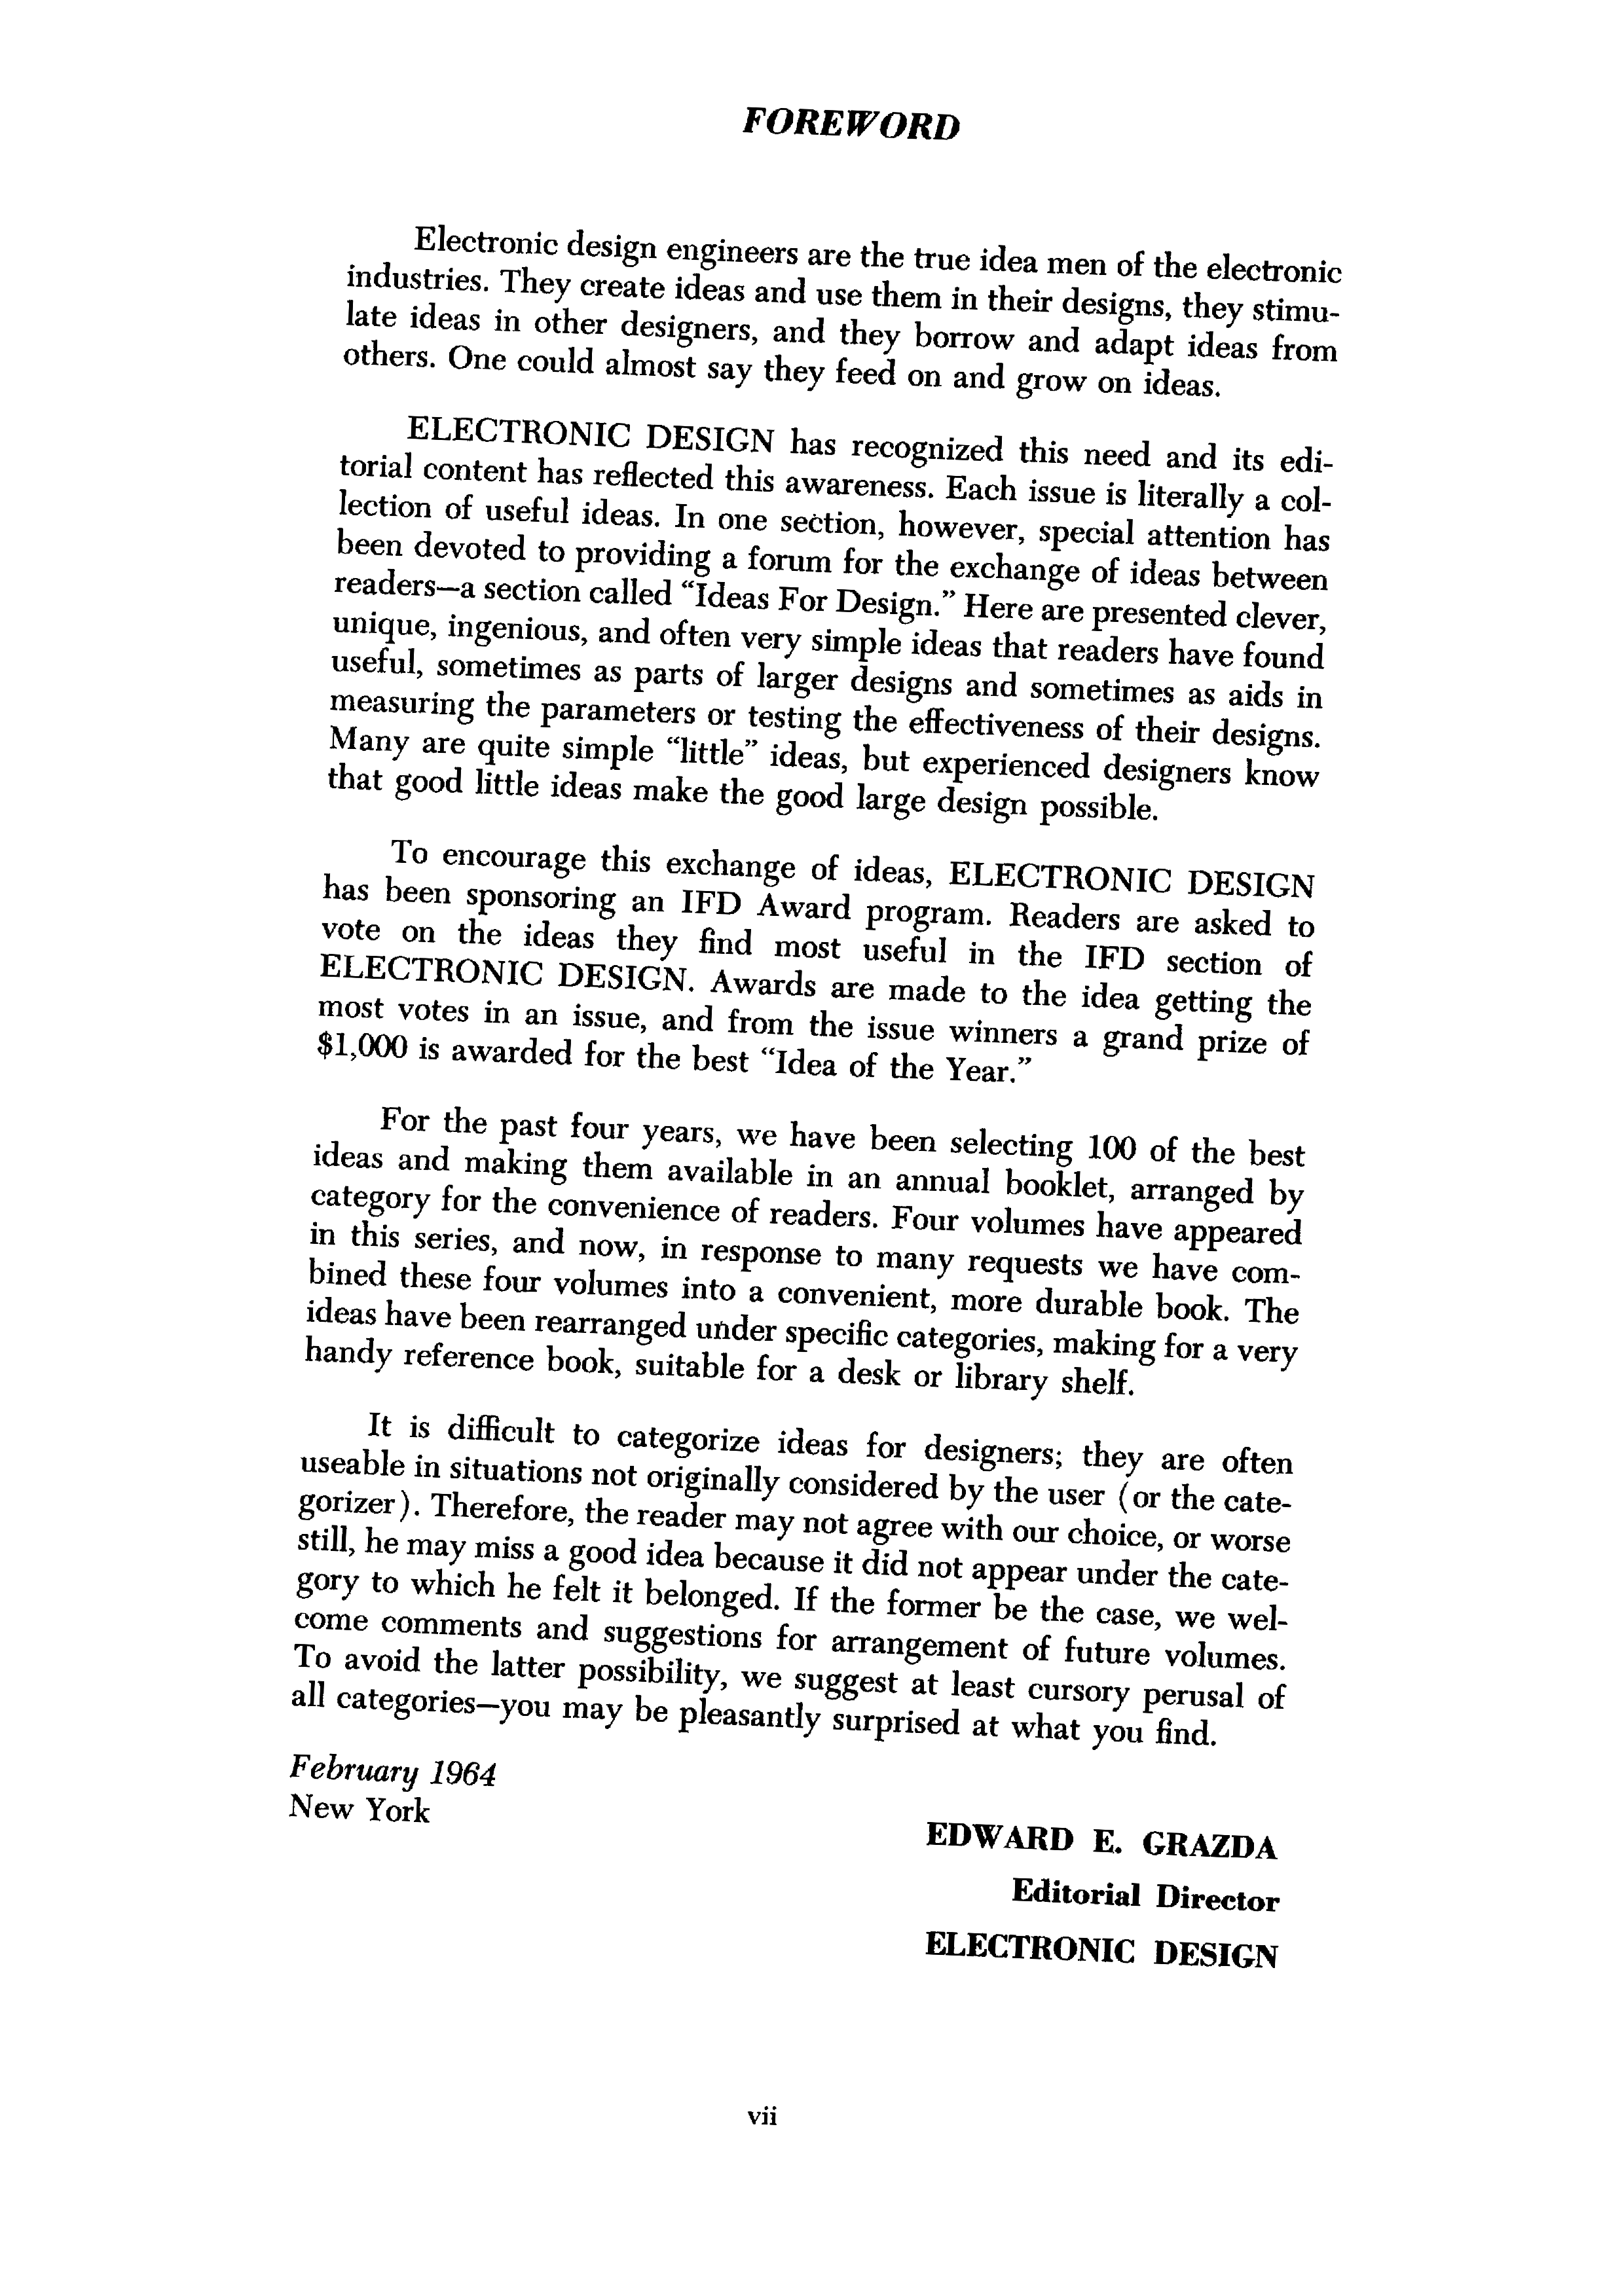


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf
    Resolution: 300 dpi
    Width: 2600 px
    Height: 3591 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


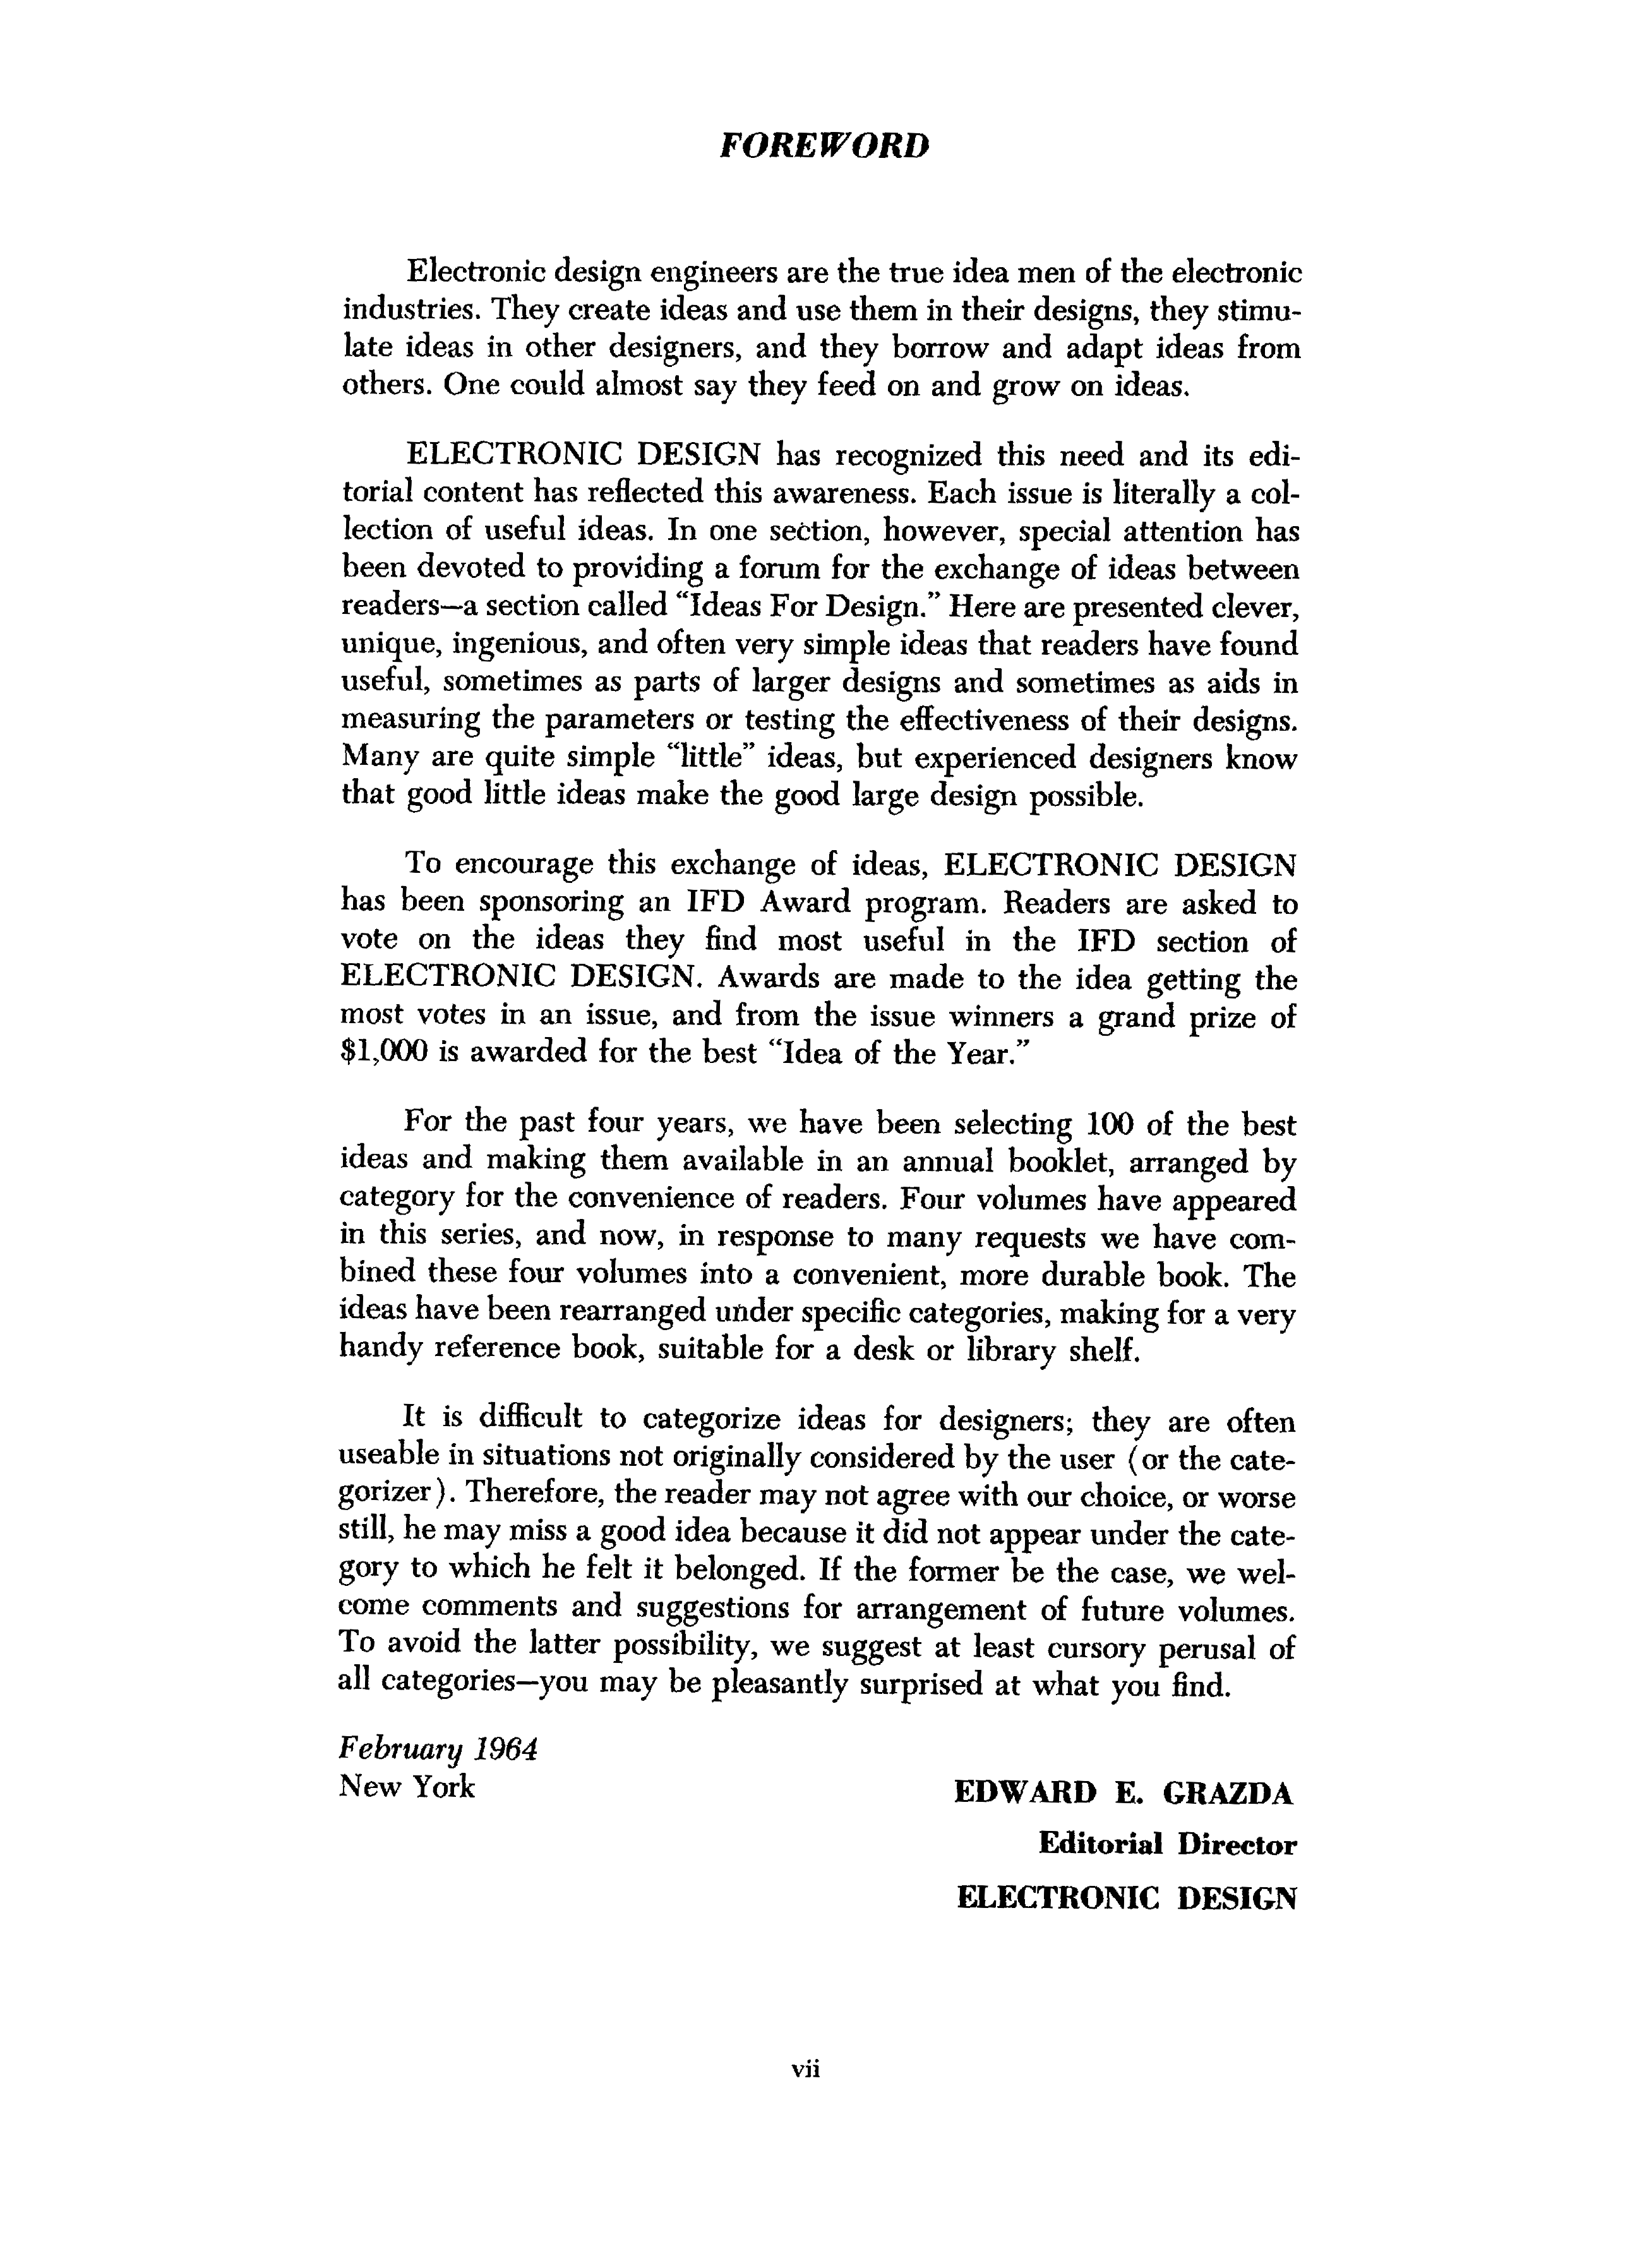

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id

In [8]:
for r in result.distinct().collect():
  display_image(r.image)
  display_image(r.corrected_image)
  print (r.text)

Saving intermediate processing results as jpg

In [9]:
for r in result.distinct().collect():

    img = to_pil_image(r.corrected_image, r.corrected_image.mode)
    img.save('corrected.jpg')
